# Hybrid Approximate Nearest Neighbors Algorithm for Movie Recommendations

## By Cody Zupnick, Kathy Lin and Priya Medberry

Our objective will be to maximize the accuracy of the recommendations provided to Movielens users when considering the results of recommending the Top-5 movies for a given user. For this purpose, we will be using a dataset from Movielens with over 10 million ratings. This notebook contains 5 sections: 
1.  Business Objectives/Background
2.  Exploratory Data Analysis
3.  Motivation for Hybrid Model
4.  Implementation of Hybrid Model
5.  Performance of Hybrid Model


Firstly, we'll provide some background on the business objectives of Movielens. Then we'll dive into the dataset and conduct some exploratory data analysis. Then we will describe the motivation and implementation of a hybrid model used to produce these recommendations. Lastly, we will compare the performance of our designed hybrid model against the performance of prior models such as a raw item-based collaborative filtering model, and the matrix factorization model. 

### 1. Business Objectives/Background
 MovieLens is a web-based recommender system and virtual community that recommends movies for its users to watch, based on their film preferences using CF of members' movie ratings and reviews. As with any recommendation system, the business objective is to build trust between the consumer and the recommendation system by providing accurate predictions of items that a consumer may like based on history of user interactions with the system (both implicitly and explicitly). For the purposes of this dataset, we'll be focusing solely on explicit ratings provided in the past by the users. In our case, people tend to like movies that are similar to other movies they like, and they tend to have similar taste to others they are close with. So as a business, we will try to capture these behavioral patterns to help predict what movies an individual hasn't watched and help expose those users to potential movies we think they'd like.
 
 However, it is important to note early on that there are often 3 types of common challenges with implementing these algorithms for the purpose of provide accurate recommendations: time, scale and quality. Although it is nice to produce accurate recommendations in a short period of time given large numbers of users and movies, there is a tradeoff between computation time and the number of movies / users in the system. Likewise, the faster an algorithm runs, which is also known as more scalability, the worse quality recommendations it usually provides. Therefore, we have designed in this project a potential solution to this tradeoff triangle. We'd still like to maximize accuracy in a reasonable period of time for a large number of users and movies. Therefore, we will use a hybrid model of approximate nearest neighbors method (item-based collaborative filtering method) with a dimensionality reducing algorithm. This hybrid model will be able to counteract the problem of scalability.


 ### 2. Exploratory Data Analysis

We start by trying to understand the Movielens 10M dataset a bit better. There are two main datasets we will be working with: **Movies.dat** and **Ratings.dat**


** 1. Movies.dat**

Each line of this file represents one movie, and has the following format: MovieID::Title::Genres
MovieID is the real MovieLens id.

Movie titles, by policy, should be entered identically to those found in IMDB, including year of release. However, they are entered manually, so errors and inconsistencies may exist.Genres are a pipe-separated list, and are selected from the following: Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western


** 2. Ratings.dat **

All ratings are contained in the file ratings.dat. Each line of this file represents one rating of one movie by one user, and has the following format:

UserID::MovieID::Rating::Timestamp

The lines within this file are ordered first by UserID, then, within user, by MovieID. Ratings are made on a 1-5 star scale, with half-star increments. Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

We read in these datasets using the Pandas library:

In [2]:
import pandas as pd

moviescol = ['MovieId', 'Title', 'Genres','Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

ratings = pd.read_csv('./ratings.dat', sep = '::', names = ['UserId', 'MovieId', 'Rating', 'Timestamp'], engine = 'python')
movies = pd.read_csv('./movies.dat', sep ='::', names = moviescol, engine='python')

KeyboardInterrupt: 

In order to determine the most appropriate way to sample our data, we first need to get a better understanding of the sparsity level of the user-item matrix. To do this, we can calculate the Sparsity level of a matrix by using 1- (nonzero entries/total entries)]

In [ ]:
n_users = ratings['UserId'].nunique()
n_items = ratings['MovieId'].nunique()

print 'Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)+ '\n' +'Number of ratings = ' + str(ratings.shape[0])

sparsity = round(1.0-len(ratings)/float(n_users*n_items),3)
print 'The sparsity level of MovieLens10M is ' +  str(sparsity*100) + '%'

There are clearly more users than there are number of movies. And the sparsity of our 10 million ratings dataset is quite high at 98.7%. We've plotted a histogram to get a better idea of the behavior of our dataset: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(10,5))

g1= sns.distplot(ratings['MovieId'])
ax.set_ylabel('Proportion of Users who have watched given Movie')
ax.set_xlabel('MovieID')
ax.set_title('# Users for each Movie')
plt.show(g1);

To avoid confusion, there are 10677 unique movies but their MovieId's range from 122 to 63662. It is important to note that there is clearly a long tail distribution amongst MovieIds; that is, many items in the long tail (right side portion of the graph) have clearly fewer ratings than those movies to the left. This makes it harder to build an algorithm that recognizes similar behavior / recommends these rare movies. However, it may prove to be valuable to recommend these movies in the long tail as they are rare obscure items that are not very popular. As a recommender system, we should also value novelty, diversity and serendipity when recommending movies to users. Because of this long tail behavior, we have to be particularly careful in how we "learn to rank" which movies make it to our top-5 recommendations list.

### 3. Motivation for Hybrid Model
One of the simplest approaches we could take to recommend the top 5 movies, is to recommend the movies liked by the most number of users; that is, the most popular items. Although this is a very efficient approach, it has a major drawback -- there is absolutely no personalization involved. Therefore, we have chosen not to move forward with this approach since the most popular items would be the same for each user, and everyone would see the same results. We felt that this methodology would not promote trust between our movie recommendation system and consumers. Also given our long tailed distribution, we could be losing out on potential diverse, novel and serendipitous recommendations provided to users that aren't among the most popular movie recommendations.

Next, we consider item-based collaborative filtering (approximate nearest neighbors method). Intuitively, we had mentioned earlier that people tend to like similar items to users who behaved similarly in the past. Item-based collaborative filtering will take a movie, find users who liked that movie, and find other movies that those users or similar users have liked. In otherwords, we compute the similarity between users and items and consider the closest items and users in these "neighborhoods". Therefore, we can provide our consumers a transparent reason behind their recommendations that is similar to "Users who have liked this movie also liked...", which again would promote trust between users and the system. Other benefits of this method include its stability in changes of ratings values and its increased robustness to potential shilling attacks from our competitors.

However, there are two major drawbacks of this method as well that we've discovered previously. Firstly, it doesn't scale particularly well with massive datasets; therefore, we're wary of proceeding with purely an approximate nearest neighbors approach with over 10 million ratings in our dataset. Next, there's a concern about quality of recommendations. Given our exploratory analysis shows that there is a high level of sparsity in our dataset, we may be computing similarity between items and users purely on noise inherent in the data. In other words, we may be constructing neighbors matched on sparse, low-level details that we assume represent the user's preference vectors instead of matching on the vectors inherent in the data itself. For example, if one user has watched the first four Harry Potter movies and another watched the last four, the raw user item matrix constructed in this approximate nearest neighbors method wouldn't have any overlap between these two users. Therefore, they'd lie in separate neighborhoods, even though it is clear that these two users share some underlying preferences. 


Therefore, we'd like to build a hybrid model that combines another method with the approximate nearest neighbors method to overcome this apparent issue. This method would derive both tastes and preferences from the data using matrix factorization, particularly, singular value decomposition.For our model-based method, we chose to implement SVD, a memory-based collaborative algorithm that decomposes the original ratings matrix into two lower dimensional matrices for users and items that shares a joint latent vector space. These latent factors are low-dimension patterns in the data because a user's preferences tend to cluster. The algorithm works such that the original matrix is decomposed into two matrices for which their product minimizes the reconstruction error (or the difference between their product and the original matrix value) over the set of all user-object values. Matrix factorization is useful because of its utility in identifying the latent factors that may not be visible from just glancing at the data and accounting for these factors in the final recommendation to the user. Thus, in this particular business case, matrix factorization can find some of the more hidden similar factors between viewer-movie ratings and account for it in the matrix decomposition in order to enable the best movie recommendation.


Given the original matrix of users and items, SVD will compress this matrix into a simpler approximation that maintains only the top k (most important) features in the data. By reducing the dimensionality of the original ratings matrix, we naturally reduce the sparsity and intuitively should improve the accuracy and efficiency of our original pure approximate nearest neighbors method on this newly reduced matrix. 


We'll describe the implementation of our hybrid model in the next section.

### 4. Implementation of the Hybrid Model
As described earlier, the general methodology of our model is to firstly use Singular Value Decomposition (SVD) to find the most important features within our sparse dataset (and consequently sparse user-movie ratings matrix). 

Once we've reduced the dimensionality of that original matrix, we can then proceed with an approximate nearest neighbors method, in particular the item-based collaborative filtering algorithm as follows: 
1. Define a set of mutually observed users that have specified ratings for movie i and j 
2. Compute similarity between movie i and movie j using Pearson's correlation
3. Find top k matching items to movie i for which user u has specified ratings. The weighted average of these ratings is reported as the predicted rating value of that particular item.

To reiterate, our objective is to maximize the accuracy of the top 5 movie recommendations users would enjoy out of those they have not seen yet. 


** FILL IN IMPLEMENTATION HERE PLEASE :) **

### 5. Performance of the Hybrid Model
In order to evaluate our hybrid approximate nearest neighbors model, we varied the following hyperparameters

- Sample Size: (5000 users, 100 items), (10000 users, 200 items) and (15000 users, 500 items)
- Similarity Distance Metric (Pearsons vs Adjusted Cosine)
- Neighborhood size: 5,10,15,20,25,30,35,40,45,50,55
- Number of Latent Factors: 5,10,15,20,25,30,35,40,45,50,55

We chose to minimize the MAE: Mean Absolute Error as it is a frequently used metric for item based collaborative filtering and is easy to understand.

#### (i) Accuracy on Training/Test Data
As a remark, it took several hours to run our model and produce offline predictions. For accuracy we can take a look at MAE and RMSE of the models over a baseline. Our baseline model was as simple as we could make it, predicting the mean rating across the entire set. Our `evaluate` method returns a hash with the MAE, RMSE for the test and train predictions. We ran our models (offline) across a wide range of hyperparameters, using k-values and latent factors of [5, 10, 15...55]. Some of the results are plotted below. 

The errors are much smaller on training data for obvious reasons, but even on test data we beat the baseline by a large amount. For reference, the baseline, the simple average across all ratings, was around 0.8 for most runs.

##### Size of the Neighborhood
Intuitively, the size of the neighborhood has significant impact on the prediction quality on a raw item-based model. So to determine the sensitivity of this parameter, we varied the number of neighbors used and observed its effect on MAE. Our results are shown below for the hybrid model. Interestingly enough, this seems to be perform worse than the baseline of 0.8.  In general, when the neighborhood size K is small, we're forcing our classifier to be "more blind" to the overall distribution. A small K will have low bias but higher variance. On the other hand, a higher K averages more voters in each prediction and is more resilient to outliers. This consequently results in lower variance but increased bias. It's also important to note that as the sample size varied and the neighborhood size varied, we did not see significant increases or decreases among the MAE values. Varying the neighborhood size did not have a tremendous effect on our hybrid model's accuracy.

  Sample_Size                                k  \
0     1000,20  [5, 10, 15, 20, 25, 30, 35, 40]   
1     1500,50  [5, 10, 15, 20, 25, 30, 35, 40]   
2      500,10  [5, 10, 15, 20, 25, 30, 35, 40]   

                                                 MAE  
0  [1.34544016576, 1.34544016576, 1.34544016576, ...  
1  [0.914452557593, 0.914452557593, 0.91445255759...  
2  [1.83864131079, 1.83864131079, 1.83864131079, ...  


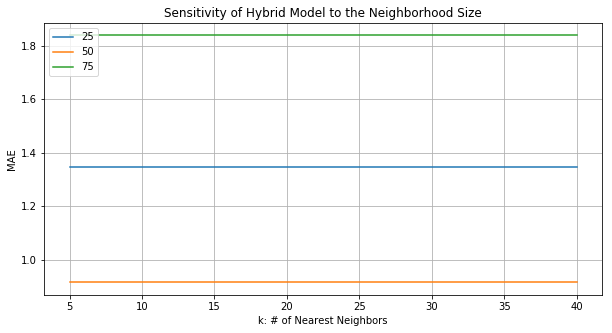

In [4]:
# reading the JSON data using json.load()
import json
import matplotlib.pyplot as plt
import pandas as pd

file = 'knnVsMae.json'

with open(file) as knnVsMAE:
    file_knnVsMAE = json.load(knnVsMAE)

# converting json dataset from dictionary to dataframe
KMdf= pd.DataFrame.from_dict(file_knnVsMAE, orient='index')
KMdf= KMdf.reset_index(drop=False)
KMdf.columns = ['Sample_Size', 'k', 'MAE']
print KMdf

k = KMdf['k'][0]
Sample1MAE = KMdf['MAE'][0]
Sample2MAE = KMdf['MAE'][1]
Sample3MAE = KMdf['MAE'][2]
#Creating the plot
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(k, Sample1MAE, k, Sample2MAE, k, Sample3MAE)
ax.set_ylabel('MAE')
ax.set_xlabel('k: # of Nearest Neighbors')

# Set the chart's title
ax.set_title('Sensitivity of Hybrid Model to the Neighborhood Size')
plt.legend(['25', '50', '75', '100'], loc = 'upper left', frameon=True)
# plt.legend(['5000 users,100 items', '10000 users, 200 items', '15000 users,500 items'],loc='upper left', frameon=True)
plt.grid()
plt.show()


##### Number of Latent Factors
Similarity, the number of latent factors used for our matrix factorization impacts our prediction quality as well. We analyzed the sensitivity of this parameter. Note that larger sample sizes does indeed outperform the smallest sample sizes at higher number of latent factors. And as the number of latent factors seems to be positively correlated with our model based algorithm's performance across all sample sizes (with  fluctuations). Our model outperformed the baseline model which had a MAE of 0.8. More investigation is needed to verify why the graph appears to be quite noisy.

  Sample_Size                                f  \
0     1000,20  [5, 10, 15, 20, 25, 30, 35, 40]   
1     1500,50  [5, 10, 15, 20, 25, 30, 35, 40]   
2      500,10  [5, 10, 15, 20, 25, 30, 35, 40]   

                                                 MAE  
0  [0.657352362436, 0.659389801309, 0.66265613388...  
1  [0.63811602547, 0.653008599374, 0.664129510455...  
2  [0.664349628807, 0.687993910808, 0.64673960433...  


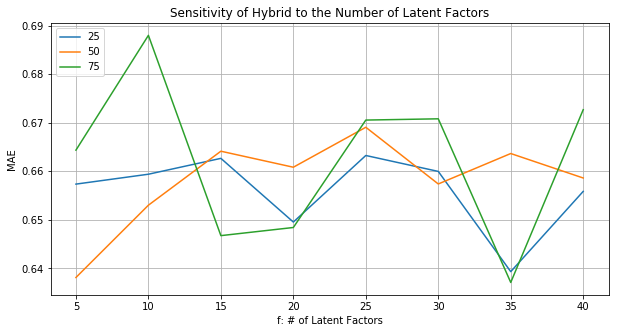

In [7]:
#MAE vs Latent Factors
file = 'mfsVsMae.json'

with open(file) as mfsVsMAE:
    file_mfsVsMAE = json.load(mfsVsMAE)

# converting json dataset from dictionary to dataframe
MFSdf= pd.DataFrame.from_dict(file_mfsVsMAE, orient='index')
MFSdf= MFSdf.reset_index(drop=False)
MFSdf.columns = ['Sample_Size', 'f', 'MAE']
print MFSdf

f = MFSdf['f'][0]
Sample1MFS = MFSdf['MAE'][0]
Sample2MFS = MFSdf['MAE'][1]
Sample3MFS= MFSdf['MAE'][2]
# BaselineMAE = len(k)*[INSERT BASELINE MAE HERE]

#Creating the plot
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(f, Sample1MFS, f, Sample2MFS, f, Sample3MFS)
ax.set_ylabel('MAE')
ax.set_xlabel('f: # of Latent Factors')

# Set the chart's title
ax.set_title('Sensitivity of Hybrid to the Number of Latent Factors')
plt.legend(['25', '50', '75', '100'], loc = 'upper left', frameon=True)
# plt.legend(['5000 users,100 items', '10000 users, 200 items', '15000 users,500 items'],loc='upper left', frameon=True)
plt.grid()
plt.show()

##### Comparison of Hybrid to Pure Models
Lastly, we'd like to compare the accuracy of the hybrid to the raw item based CF algorithm, baseline, and Matrix Factorized (model based) model across various number of items. Our results are shown below. Our hybrid model is an improvement over the pure approximate nearest neighbors method. However, both the approximate nearest neighbors method and the hybrid perform quite poorly compared to the baseline average MAE of 0.8. The raw matrix factorization method is the only model that beats our baseline.

   m_items   model       mae
0       10     knn  1.838641
1       20     knn  1.345440
2       50     knn  0.914453
3       10      mf  0.670802
4       10  hybrid  1.626545
5       20      mf  0.659967
6       20  hybrid  1.222704
7       50      mf  0.657382
8       50  hybrid  0.909485


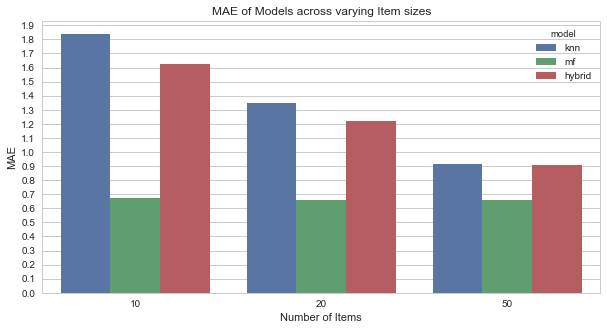

In [11]:
#MAE of Models across Item Sizes
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
%matplotlib inline
sns.set(style="whitegrid")

itemMAEdf = pd.read_csv('item_size_vs_MAE.csv', sep = ',')
print itemMAEdf

fig, ax = plt.subplots(figsize=(10,5))

g1 = sns.barplot(x='m_items', y = 'mae', hue = 'model', data = itemMAEdf)
ylist = [.1*x for x in range(20)]
g1.set(yticks=ylist)

plt.ylabel('MAE')
plt.xlabel('Number of Items')
plt.title('MAE of Models across varying Item sizes')

plt.show(g1);

#### (ii) Coverage on training/test data
We used catalog coverage to see how well we were recommending all of the items in our movie catalog. **INSERT COVERAGE NUMBERS HERE.** In general, we covered the most popular movies well, but didn't get a lot of the long tail once our item set increased. If we wanted to cover more items (potentially at the cost of accuracy) we could give additional weight to less rated items. This will increase novelty for our users, potentially at the risk of recommending movies they are less likely to enjoy. 

#### (iii) Model Size Variation
As mentioned earlier, intuitively we'd expect the runtime of all algorithms to increase as our model size increases. The figure below validates this intuition. However, a counterintuitive observation is that our hybrid model actually takes longer to run than the pure item-based model. Part of the reason we proposed the hybrid was to make it more scalable. As you can see by the plot below, for smaller model sizes, item based CF algorithms actually perform faster than the Matrix Factorization counterpart. Matrix factorization performs significantly faster than the other two models.

   m_items   model       time
0       10     knn   0.757292
1       20     knn   2.428233
2       50     knn  10.753576
3       10      mf   0.402517
4       10  hybrid   1.134754
5       20      mf   0.895229
6       20  hybrid   3.698438
7       50      mf   1.935920
8       50  hybrid  18.772627


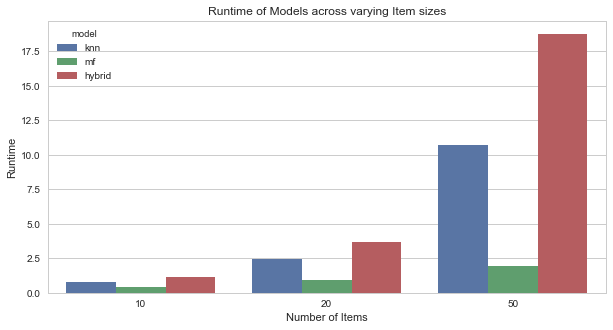

In [9]:
#MAE vs Neighborhood size

itemtimedf = pd.read_csv('item_size_vs_time.csv', sep = ',')
print itemtimedf

fig, ax = plt.subplots(figsize=(10,5))

g2 = sns.barplot(x='m_items', y = 'time', hue = 'model', data = itemtimedf)
ylist = [.1*x for x in range(10)]
g1.set(yticks=ylist)

plt.ylabel('Runtime')
plt.xlabel('Number of Items')
plt.title('Runtime of Models across varying Item sizes')
sns.set()
plt.show(g2)

### Conclusion
Our hybrid model offers several benefits:
1. **Explainability:**  
As mentioned earlier, we can build trust with users given accurate predictions by also sharing the reason for those recommendations. This is a property inherent in item-based collaborative filtering algorithms. This not only enriches the user experience, but also encourages users to provide more input to the system so we can ultimately improve long-term accuracy. It is important to note that matrix factorization with SVD alone could not have provided these clear explanations for predictions.
2. **Fewer parameters:**
By incorporating SVD as a first step, we've lowered the complexity and sparsity of our ratings matrix before proceeding with the approximate nearest neighbors method. In terms of the tradeoff triangle, we've increased scalability and decreased amount of time needed to process that matrix in hopes of improving quality of recommendations.
3. ** New Users: **
With our incorporation of the item-based collaborative filtering model, we can handle new users as soon as they provide feedback to the system without a long waiting period of retraining the model and estimating new parameters. We can also immediately use those new ratings to update user preferences. From a business perspective, given that the MovieLens' system already counteracts the Cold start problem by asking new users to rate how much they enjoy watching different genres of movies, we can further counteract the problem with this property of item based CF.

As we realized with the implementation and performance sections of our hybrid model, there are still limitations to it. Firstly, computing the similarity matrix for item based CF is still a computationally expensive problem and will take significant time offline. However, since we’re optimizing for accuracy and not scalability in our business scenario, we’re willing to make this tradeoff. Also, one of our first discoveries in the exploratory data analysis section was the long tailed distribution of our dataset. The basic matrix factorization method of collaborative filtering can't discover this long tail distribution and effectively "learn to rank" the proper movies for our top 5 recommendations. That's why we'd recommend turning to a combination of content filtering and approximate nearest neighbor methods as a next step. Content filtering (grouping by tags, genres, or reviews) can provide additional links within our data to improve neighborhood construction. Another major insight beyond this project is that improved recommendation quality can rely on factoring implicit user feedback as well.